In [16]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.decomposition import PCA
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [4]:
def build_preprocessor(num_cols, cat_cols):
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output= False))
    ])

    return ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])


In [6]:
def build_preprocessor_with_pca(num_cols, cat_cols, pca_variance=0.95):
    # Preprocesador original sin cambios
    preprocessor = build_preprocessor(num_cols, cat_cols)

    # Pipeline que aplica preprocesamiento + PCA
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=pca_variance, svd_solver='full'))
    ])

    return pipeline

In [7]:
def build_keras_model(input_shape, hidden_units=64, learning_rate=0.001, dropout_rate=0.3):
    model = models.Sequential([
        layers.InputLayer(shape=input_shape),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'recall']
    )
    return model

In [8]:
df = pd.read_csv("data/dataset_practica_final.csv")
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [9]:
target_col = 'is_canceled'
X = df.drop(columns=['is_canceled', 'reservation_status', 'reservation_status_date'])
y = df[target_col]

#Ingeniería de columnas para eliminar columnas altamente correlacionadas
X['arrival_time_index'] = X['arrival_date_year'] + (X['arrival_date_week_number'] / 52)
X = X.drop(columns=['arrival_date_year', 'arrival_date_week_number'])


num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

num_imputer = SimpleImputer(strategy='constant', fill_value=0)
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = build_preprocessor(num_cols, cat_cols)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [10]:
sklearn_models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10]
    }),
    'DecisionTree': (DecisionTreeClassifier(), {
        'max_depth': [5, 10, 20]
    }),
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [10, 20]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [50, 100],
        'max_depth': [3, 6]
    })
}

In [11]:
preprocessor = build_preprocessor(num_cols, cat_cols)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

results = []
sklearn_results = {}

for name, (model, param_grid) in sklearn_models.items():
    print(f"\nSearching best params for: {name}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='recall',  # criterio de selección
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train_processed, y_train)

    # Guardamos el modelo completo
    sklearn_results[name] = grid

    # Predecimos en el test set
    y_pred = grid.predict(X_test_processed)
    y_prob = grid.predict_proba(X_test_processed)[:, 1] if hasattr(grid, 'predict_proba') else None

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Guardamos los resultados en una lista
    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'roc_auc': auc
    })

    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Test metrics - Acc: {acc:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")


Searching best params for: LogisticRegression
Best params for LogisticRegression: {'C': 10}
Test metrics - Acc: 0.8198, Prec: 0.8135, Recall: 0.6661, AUC: 0.8963

Searching best params for: DecisionTree
Best params for DecisionTree: {'max_depth': 20}
Test metrics - Acc: 0.8683, Prec: 0.8250, Recall: 0.8179, AUC: 0.9151

Searching best params for: RandomForest
Best params for RandomForest: {'max_depth': 20, 'n_estimators': 50}
Test metrics - Acc: 0.8723, Prec: 0.9037, Recall: 0.7334, AUC: 0.9488

Searching best params for: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:03:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'max_depth': 6, 'n_estimators': 100}
Test metrics - Acc: 0.8815, Prec: 0.8631, Recall: 0.8083, AUC: 0.9536


In [19]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='recall', ascending=False)

,model,best_params,accuracy,precision,recall,roc_auc
1,DecisionTree,{'max_depth': 20},0.868289,0.825046,0.817863,0.915132
3,XGBoost,"{'max_depth': 6, 'n_estimators': 100}",0.881481,0.863093,0.808253,0.953614
4,Keras,"{'lr': 0.01, 'dropout_rate': 0.2}",0.864185,0.857453,0.759638,0.939540
2,RandomForest,"{'max_depth': 20, 'n_estimators': 50}",0.872309,0.903734,0.733409,0.948831
0,LogisticRegression,{'C': 10},0.819750,0.813475,0.666139,0.896343


In [23]:
results_dict = {}
results_pca = []

preprocessor_pca = build_preprocessor_with_pca(num_cols, cat_cols, pca_variance=0.95)
X_train_processed = preprocessor_pca.fit_transform(X_train)
X_test_processed = preprocessor_pca.transform(X_test)


for name, (model, param_grid) in sklearn_models.items():
    print(f"\nSearching best params for: {name}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='recall',
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train_processed, y_train)
    results[name] = grid

     # Predecimos en el test set
    y_pred = grid.predict(X_test_processed)
    y_prob = grid.predict_proba(X_test_processed)[:, 1] if hasattr(grid, 'predict_proba') else None

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Guardamos los resultados en una lista
    results_pca.append({
        'model': name,
        'best_params': grid.best_params_,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'roc_auc': auc
    })

    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best recall: {grid.best_score_:.4f}")



Searching best params for: LogisticRegression
Best params for LogisticRegression: {'C': 10}
Best recall: 0.6444

Searching best params for: DecisionTree
Best params for DecisionTree: {'max_depth': 20}
Best recall: 0.7530

Searching best params for: RandomForest
Best params for RandomForest: {'max_depth': 20, 'n_estimators': 50}
Best recall: 0.7465

Searching best params for: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:59:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'max_depth': 6, 'n_estimators': 100}
Best recall: 0.7625


In [32]:
results_pca_df = pd.DataFrame(results_pca)
results_pca_df.sort_values(by='recall', ascending=False)

,model,best_params,accuracy,precision,recall,roc_auc
1,DecisionTree,{'max_depth': 20},0.827205,0.771425,0.758168,0.824373
3,XGBoost,"{'max_depth': 6, 'n_estimators': 100}",0.863389,0.856832,0.757829,0.937596
2,RandomForest,"{'max_depth': 20, 'n_estimators': 50}",0.872770,0.884824,0.754777,0.943027
0,LogisticRegression,{'C': 10},0.807731,0.801275,0.639570,0.881089


In [13]:
keras_params = {
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32],
    'epochs': [10]
}

best_score = 0
best_model = None
best_params = {}

for lr in keras_params['learning_rate']:
    for dr in keras_params['dropout_rate']:
        print(f"Training model with lr={lr}, dr={dr}")
        model = build_keras_model(
            input_shape=(X_train_processed.shape[1],),
            learning_rate=lr,
            dropout_rate=dr
        )

        history = model.fit(
            X_train_processed, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            verbose=0,
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
        )

        # Evaluate based on max validation recall
        val_recall = max(history.history['val_recall'])
        if val_recall > best_score:
            best_score = val_recall
            best_model = model
            best_params = {'lr': lr, 'dropout_rate': dr}

print("\nEvaluating best Keras model on test set...")

y_pred_prob = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

results.append({
    'model': 'Keras',
    'best_params': best_params,
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'roc_auc': auc
})

print(f"Keras best params: {best_params}")
print(f"Keras Test metrics - Acc: {acc:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")


Training model with lr=0.001, dr=0.2
Training model with lr=0.001, dr=0.3
Training model with lr=0.01, dr=0.2
Training model with lr=0.01, dr=0.3

Evaluating best Keras model on test set...
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Keras best params: {'lr': 0.01, 'dropout_rate': 0.2}
Keras Test metrics - Acc: 0.8642, Prec: 0.8575, Recall: 0.7596, AUC: 0.9395


In [18]:
results_df = pd.DataFrame(results)
results_df

,model,best_params,accuracy,precision,recall,roc_auc
0,LogisticRegression,{'C': 10},0.819750,0.813475,0.666139,0.896343
1,DecisionTree,{'max_depth': 20},0.868289,0.825046,0.817863,0.915132
2,RandomForest,"{'max_depth': 20, 'n_estimators': 50}",0.872309,0.903734,0.733409,0.948831
3,XGBoost,"{'max_depth': 6, 'n_estimators': 100}",0.881481,0.863093,0.808253,0.953614
4,Keras,"{'lr': 0.01, 'dropout_rate': 0.2}",0.864185,0.857453,0.759638,0.939540


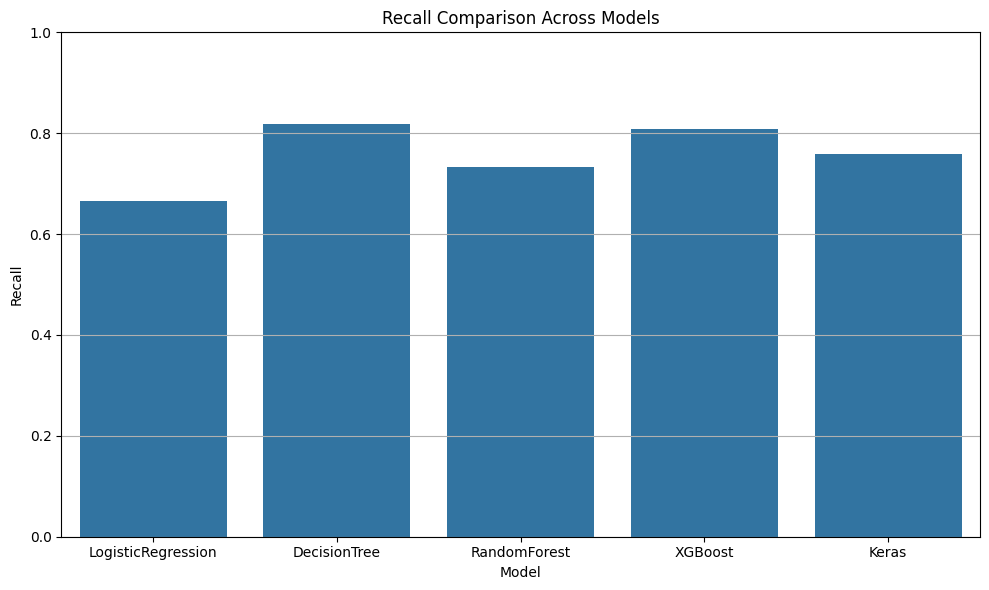

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='model', y='recall')
plt.title('Recall Comparison Across Models')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()